In [41]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from numpy import zeros, newaxis
from evaluation.evaluate import evaluate
from sklearn.preprocessing import MinMaxScaler

import tensorflow.keras
from common.data_loader import *
from common.preprocessing import * 
from tensorflow.keras import Input
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU,Conv1D ,Dropout,Conv1DTranspose, Bidirectional, TimeDistributed,RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from datetime import datetime
from os import path, environ
from livelossplot import PlotLossesKeras
import matplotlib.pyplot as plt

environ["CUDA_VISIBLE_DEVICES"] = "2"
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)


In [42]:
SEQ_LEN = 2
BATCH_SIZE = 256 
EPOCHS = 1000

In [43]:
# Load dataset
# full_data = pd.read_csv("data/wtbdata_245days.csv")
train_data = pd.read_csv("data/train_data.csv")
submission = pd.read_csv("data/sample_submission.csv")
# test_data = pd.read_csv("info/target.csv")
# full_data = full_data.fillna(method = 'bfill')
# train_data = train_data.fillna(method = 'bfill')
# full_data.info()

In [44]:
train_data = impute_data(train_data)

* Data name: Imputing
  - Number of data: 3823222
  - Number of nan rows: 0


In [45]:
train_data = outlier_handler(train_data, ['Etmp','Itmp'])

Day  1
      Etmp Fence High/Low (44.795/16.834999999999997), Count: 2836
      Etmp_diff Fence High/Low (0.6149999999999967/-0.6249999999999982), Count: 2343
      Itmp Fence High/Low (51.23500000000001/19.994999999999997), Count: 330
      Itmp_diff Fence High/Low (0.6950000000000038/-0.7050000000000018), Count: 3018
Day  2
      Etmp Fence High/Low (39.194913229474345/14.419052062315394), Count: 1552
      Etmp_diff Fence High/Low (0.5400531219352516/-0.5439939522719683), Count: 913
      Itmp Fence High/Low (47.40117419908326/18.88729548055004), Count: 408
      Itmp_diff Fence High/Low (0.5699999999999896/-0.5499999999999865), Count: 1201
Day  3
      Etmp Fence High/Low (39.02466492317804/14.158891794703267), Count: 1450
      Etmp_diff Fence High/Low (0.4250000000000007/-0.4150000000000027), Count: 1198
      Itmp Fence High/Low (46.73196367276783/19.4328217963393), Count: 380
      Itmp_diff Fence High/Low (0.48712446878064686/-0.484274681268384), Count: 1407
Day  4
      Etmp 

Day  26
      Etmp Fence High/Low (37.71/6.43), Count: 1591
      Etmp_diff Fence High/Low (0.5587553121935249/-0.5045921869892078), Count: 1276
      Itmp Fence High/Low (45.89950977988329/10.556294132070024), Count: 352
      Itmp_diff Fence High/Low (0.6672086344285963/-0.5981950597783205), Count: 1835
Day  27
      Etmp Fence High/Low (40.223127253426384/11.40458523034027), Count: 1600
      Etmp_diff Fence High/Low (0.5829838182412308/-0.5265181976680617), Count: 2011
      Itmp Fence High/Low (48.66/15.940000000000001), Count: 208
      Itmp_diff Fence High/Low (0.679164759725392/-0.6252745995423261), Count: 2058
Day  28
      Etmp Fence High/Low (39.44217881660559/11.294692710036646), Count: 1540
      Etmp_diff Fence High/Low (0.6480368911036951/-0.6533948185061629), Count: 893
      Itmp Fence High/Low (47.945622752532735/16.673971886237133), Count: 204
      Itmp_diff Fence High/Low (0.719078802335753/-0.7180157221015033), Count: 1003
Day  29
      Etmp Fence High/Low (41.584

Day  51
      Etmp Fence High/Low (44.25078497326828/20.66552901603903), Count: 1518
      Etmp_diff Fence High/Low (0.39376566416038195/-0.44532641386071425), Count: 2930
      Itmp Fence High/Low (52.900086192219646/24.099948284668212), Count: 181
      Itmp_diff Fence High/Low (0.5028215920235244/-0.5702578457012049), Count: 3195
Day  52
      Etmp Fence High/Low (42.73556738313235/16.560721028112763), Count: 1549
      Etmp_diff Fence High/Low (0.45499999999999474/-0.46499999999999275), Count: 3152
      Itmp Fence High/Low (49.97535489539139/21.134408507681012), Count: 315
      Itmp_diff Fence High/Low (0.6347066034651832/-0.6311776724419715), Count: 2849
Day  53
      Etmp Fence High/Low (47.428438258401826/15.310704446701376), Count: 1472
      Etmp_diff Fence High/Low (0.5895466879029554/-0.5452260279113448), Count: 1468
      Itmp Fence High/Low (55.98138750408474/18.683167497549157), Count: 186
      Itmp_diff Fence High/Low (0.7286120191783834/-0.6815154734662787), Count: 1

Day  77
      Etmp Fence High/Low (43.41325152424663/18.17604908545202), Count: 1220
      Etmp_diff Fence High/Low (0.41825337801023554/-0.44989416475971833), Count: 3194
      Itmp Fence High/Low (48.559542538409744/23.024274476954158), Count: 399
      Itmp_diff Fence High/Low (0.49090634194182314/-0.5248439032363734), Count: 3608
Day  78
      Etmp Fence High/Low (43.202542413603744/14.902429310660432), Count: 1271
      Etmp_diff Fence High/Low (0.4578179143511054/-0.418690748610663), Count: 2970
      Itmp Fence High/Low (48.26343984962476/19.80093358395875), Count: 265
      Itmp_diff Fence High/Low (0.5300000000000082/-0.5100000000000122), Count: 2430
Day  79
      Etmp Fence High/Low (47.22375653808299/17.361746077150208), Count: 1305
      Etmp_diff Fence High/Low (0.46947913261414875/-0.3936874795684897), Count: 1894
      Itmp Fence High/Low (51.61/21.61), Count: 171
      Itmp_diff Fence High/Low (0.5058091500164661/-0.46348549000988193), Count: 2362
Day  80
      Etmp Fen

Day  102
      Etmp Fence High/Low (46.678177100358255/19.99309373978505), Count: 1512
      Etmp_diff Fence High/Low (0.5225336365135895/-0.5205047368938942), Count: 3128
      Itmp Fence High/Low (53.49320080091432/23.441095537757416), Count: 38
      Itmp_diff Fence High/Low (0.5779781978408884/-0.6098786679717314), Count: 3729
Day  103
      Etmp Fence High/Low (42.964999999999996/19.165), Count: 1415
      Etmp_diff Fence High/Low (0.49644110275689624/-0.4918121390432768), Count: 1350
      Itmp Fence High/Low (46.34527620070061/23.126343487380964), Count: 262
      Itmp_diff Fence High/Low (0.5749999999999993/-0.5849999999999973), Count: 1432
Day  104
      Etmp Fence High/Low (48.87398373651441/16.470908657513156), Count: 1183
      Etmp_diff Fence High/Low (0.6550000000000082/-0.5850000000000009), Count: 1654
      Itmp Fence High/Low (50.30343442055667/21.881939347665995), Count: 108
      Itmp_diff Fence High/Low (0.6615053939195814/-0.5889032363517561), Count: 2847
Day  105


Day  127
      Etmp Fence High/Low (39.94616989600806/21.81966017658796), Count: 1902
      Etmp_diff Fence High/Low (0.5048345047401037/-0.48749305328538295), Count: 2166
      Itmp Fence High/Low (46.531299377090804/24.14519589125517), Count: 299
      Itmp_diff Fence High/Low (0.6133273400893522/-0.6239964040536172), Count: 2689
Day  128
      Etmp Fence High/Low (39.91180941484204/18.546984308596603), Count: 1422
      Etmp_diff Fence High/Low (0.4918689537854144/-0.47112137227124773), Count: 2292
      Itmp Fence High/Low (45.62238190585227/21.936030156912885), Count: 236
      Itmp_diff Fence High/Low (0.5700000000000092/-0.5500000000000096), Count: 2669
Day  129
      Etmp Fence High/Low (43.59311401816624/17.897563229683037), Count: 1385
      Etmp_diff Fence High/Low (0.60491745668517/-0.5709504740111004), Count: 1455
      Itmp Fence High/Low (48.63999999999999/21.520000000000003), Count: 327
      Itmp_diff Fence High/Low (0.624417157022978/-0.5883920398822982), Count: 2334


Day  152
      Etmp Fence High/Low (33.41607592350483/9.586540127491952), Count: 1700
      Etmp_diff Fence High/Low (0.6530872016998952/-0.6084786694998261), Count: 1811
      Itmp Fence High/Low (40.37628490963594/14.065338597265965), Count: 348
      Itmp_diff Fence High/Low (0.6753097417456511/-0.6721829029094328), Count: 2441
Day  153
      Etmp Fence High/Low (30.405506292905752/7.312786449820063), Count: 1610
      Etmp_diff Fence High/Low (0.635380434782606/-0.6589673913043423), Count: 1293
      Itmp Fence High/Low (36.0634847989529/12.60190912062826), Count: 439
      Itmp_diff Fence High/Low (0.684999999999997/-0.7149999999999945), Count: 2229
Day  154
      Etmp Fence High/Low (29.979453955820674/6.771205377107398), Count: 1492
      Etmp_diff Fence High/Low (0.6464239402854828/-0.6118543641712906), Count: 1389
      Itmp Fence High/Low (36.11429940339883/11.419420357960702), Count: 212
      Itmp_diff Fence High/Low (0.6644708237986263/-0.654682494279176), Count: 2353
Day 

Day  177
      Etmp Fence High/Low (28.714675942546176/5.520521665593218), Count: 1445
      Etmp_diff Fence High/Low (0.5856381443610585/-0.6027302406017627), Count: 2135
      Itmp Fence High/Low (36.61345513690974/9.540539793064776), Count: 123
      Itmp_diff Fence High/Low (0.5604658385093009/-0.5731333769205458), Count: 3519
Day  178
      Etmp Fence High/Low (25.314391958156445/3.4360134030725895), Count: 1916
      Etmp_diff Fence High/Low (0.6004560313827971/-0.6007600523046657), Count: 1115
      Itmp Fence High/Low (33.29889627260995/8.500662236434028), Count: 440
      Itmp_diff Fence High/Low (0.5712659654961172/-0.5787766091601938), Count: 1573
Day  179
      Etmp Fence High/Low (21.936191157240337/4.214285305655798), Count: 2289
      Etmp_diff Fence High/Low (0.4449534161490647/-0.42697204968943825), Count: 1602
      Itmp Fence High/Low (31.322386809415214/8.036021984307974), Count: 634
      Itmp_diff Fence High/Low (0.4699999999999971/-0.48999999999999666), Count: 22

In [46]:
# Preprocessing
train_data = feature_engineering(train_data)

In [47]:
train_data.columns

Index(['TurbID', 'Day', 'Tmstamp', 'Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1', 'Pab2', 'Pab3',
       'Prtv', 'Patv', 'locX', 'locY', 'TimeX', 'TimeY', 'DayX', 'DayY', 'Etmp_abs', 'Wdir_adj',
       'Wdir_cos', 'Wdir_sin', 'Ndir_cos', 'Ndir_sin', 'WdirX', 'WdirY', 'NdirX', 'NdirY', 'WspdX',
       'WspdY', 'WspdX_abs', 'WspdY_abs', 'TSR1', 'TSR2', 'TSR3', 'Bspd1', 'Bspd2', 'Bspd3', 'RPM',
       'Pab', 'TSR', 'Wspd_cube', 'Pmax', 'Papt', 'Patan'],
      dtype='object')

In [48]:
select_features(train_data)

Index(['TSR3', 'TSR2', 'TSR', 'TSR1', 'Pab3', 'Pab2', 'Pab', 'Pab1', 'Patan', 'Pmax', 'Wspd_cube',
       'Wspd', 'WspdX', 'Bspd2', 'Bspd3', 'Bspd1', 'RPM', 'Papt', 'Patv'],
      dtype='object')

In [49]:
data = train_data.copy()

In [50]:
data = data[data['Day']<201]

### best feature score 170

In [ ]:
features = ['TurbID','Day','RPM', 'Bspd1', 'Bspd3', 'Bspd2', 'WspdX', 'Wspd', 'Wspd_cube', 'P_max', 'Pab1', 'Pab2', 'Pab3', 'TSR1', 'TSR2', 'TSR3', 'Prtv','Patv']
train_data = train_data[features]
data = data[features]

## new feature

In [51]:
features = ['TurbID', 'Day','Tmstamp','TSR', 'Pab',  'Patan', 'Wspd_cube', 'Wspd', 'WspdX', 'RPM', 'Papt', 'Pmax', 'Patv']
# train_data = train_data[features]
data = data[features]

In [52]:
data

,TurbID,Day,Tmstamp,TSR,Pab,Patan,Wspd_cube,Wspd,WspdX,RPM,Papt,Pmax,Patv
0,1,1,0.000000,1.150368,1.00,-0.000505,233.181313,6.17,6.155045,7.080570,494.660063,513.704000,494.66
1,1,1,0.166667,1.150368,1.00,-0.000505,233.181313,6.17,6.155045,7.080570,494.660063,513.783653,494.66
2,1,1,0.333333,1.150368,1.00,-0.000471,245.957079,6.27,6.265462,7.207590,509.760056,542.050278,509.76
3,1,1,0.500000,1.150368,1.00,-0.000479,264.544863,6.42,6.419479,7.384766,542.530062,583.170108,542.53
4,1,1,0.666667,1.150368,1.00,-0.000452,244.052275,6.25,6.249246,7.188935,509.360052,538.160762,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859195,134,200,23.166667,1.191331,0.01,-0.336971,113.646913,4.86,4.843796,5.770566,327.042687,272.139465,308.65
3859196,134,200,23.333333,1.191331,0.01,-0.399805,88.069787,4.46,4.449136,5.300394,240.572254,210.968112,221.60
3859197,134,200,23.500000,1.191331,0.01,-0.466906,75.686746,4.23,4.229996,5.039326,247.042102,181.353563,220.60
3859198,134,200,23.666667,1.191331,0.01,-0.452658,81.472834,4.36,4.335151,5.164601,247.028873,195.249538,222.15


In [53]:
day = 144
hour = 6
ten_minute = 1
train_x, train_y, val_x, val_y, test_x = make_train_val_test_data(data, 
                                                                  in_seq_len=SEQ_LEN*144, 
                                                                  out_seq_len=SEQ_LEN*144, 
                                                                  stride=day, 
                                                                  shuffle=True, 
                                                                  test_size=0.1)

100%|██████████| 134/134 [00:19<00:00,  6.90it/s]


* Data Split
  - Train data(X, y)     : (23427, 288, 10) (23427, 288, 10)
  - Validation data(X, y): (2678, 288, 10) (2678, 288, 10)
  - Test data(X)         : (134, 288, 10)


In [54]:
train_x, train_y = np.array(train_x, dtype=np.float32), np.array(train_y, dtype=np.float32)
val_x, val_y = np.array(val_x, dtype=np.float32), np.array(val_y, dtype=np.float32)
test_x = np.array(test_x, dtype=np.float32)

In [55]:
data.iloc[:,3:]

,TSR,Pab,Patan,Wspd_cube,Wspd,WspdX,RPM,Papt,Pmax,Patv
0,1.150368,1.00,-0.000505,233.181313,6.17,6.155045,7.080570,494.660063,513.704000,494.66
1,1.150368,1.00,-0.000505,233.181313,6.17,6.155045,7.080570,494.660063,513.783653,494.66
2,1.150368,1.00,-0.000471,245.957079,6.27,6.265462,7.207590,509.760056,542.050278,509.76
3,1.150368,1.00,-0.000479,264.544863,6.42,6.419479,7.384766,542.530062,583.170108,542.53
4,1.150368,1.00,-0.000452,244.052275,6.25,6.249246,7.188935,509.360052,538.160762,509.36
...,...,...,...,...,...,...,...,...,...,...
3859195,1.191331,0.01,-0.336971,113.646913,4.86,4.843796,5.770566,327.042687,272.139465,308.65
3859196,1.191331,0.01,-0.399805,88.069787,4.46,4.449136,5.300394,240.572254,210.968112,221.60
3859197,1.191331,0.01,-0.466906,75.686746,4.23,4.229996,5.039326,247.042102,181.353563,220.60
3859198,1.191331,0.01,-0.452658,81.472834,4.36,4.335151,5.164601,247.028873,195.249538,222.15


In [26]:
train_x.reshape(-1,train_x.shape[2]).shape

(6746976, 10)

In [56]:
scaler = MinMaxScaler()
scaler.fit(train_x.reshape(-1,train_x.shape[2]))
train_x_scaled = scaler.transform(train_x.reshape(-1,train_x.shape[2])).reshape(-1,*train_x.shape[1:])
train_y_scaled = scaler.transform(train_y.reshape(-1,train_x.shape[2])).reshape(-1,*train_x.shape[1:])
val_x_scaled = scaler.transform(val_x.reshape(-1,train_x.shape[2])).reshape(-1,*train_x.shape[1:])
val_y_scaled = scaler.transform(val_y.reshape(-1,train_x.shape[2])).reshape(-1,*train_x.shape[1:])
test_x_scaled = scaler.transform(test_x.reshape(-1,train_x.shape[2])).reshape(-1,*train_x.shape[1:])
# test_y_scaled = scaler.transform(test_y.reshape(-1,train_x.shape[2])).reshape(-1,*train_x.shape[1:])
print("Train data(X, y):", train_x_scaled.shape, train_y_scaled.shape)
print("Validation data(X, y):", val_x_scaled.shape, val_y_scaled.shape)
print("Test data(X):", test_x_scaled.shape)

Train data(X, y): (23427, 288, 10) (23427, 288, 10)
Validation data(X, y): (2678, 288, 10) (2678, 288, 10)
Test data(X): (134, 288, 10)


In [57]:
# Generate dataset
# train_ds = generate_dataset(train_x, train_y, batch_size=BATCH_SIZE)
train_ds = generate_dataset(train_x_scaled, train_y_scaled, batch_size=BATCH_SIZE)

In [58]:
# test_ds = generate_dataset(val_x, val_y, batch_size=BATCH_SIZE)
test_ds = generate_dataset(val_x_scaled, val_y_scaled, batch_size=BATCH_SIZE)

In [59]:
model = Sequential(name="GRU-Model") # Model
model.add(Input(shape=(train_x[0].shape[0],train_x[0].shape[1]), name='Input-Layer')) # Input Layer - need to speicfy the shape of inputs
model.add(Bidirectional(GRU(units=256, activation='tanh', recurrent_activation='sigmoid', stateful=False), name='Hidden-GRU-Encoder-Layer')) # Encoder Layer
model.add(RepeatVector(train_y[0].shape[0], name='Repeat-Vector-Layer')) # Repeat Vector
model.add(Bidirectional(GRU(units=256, activation='tanh', recurrent_activation='sigmoid', stateful=False, return_sequences=True), name='Hidden-GRU-Decoder-Layer')) # Decoder Layer
# model.add(RepeatVector(train_y[0].shape[0], name='Repeat-Vector-Layer2')) # Repeat Vector
model.add(TimeDistributed(Dense(units=train_y[0].shape[1], activation='linear'), name='Output-Layer')) # Output Layer, Linear(x) = x

In [60]:
model.summary()

Model: "GRU-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden-GRU-Encoder-Layer (B  (None, 512)              411648    
 idirectional)                                                   
                                                                 
 Repeat-Vector-Layer (Repeat  (None, 288, 512)         0         
 Vector)                                                         
                                                                 
 Hidden-GRU-Decoder-Layer (B  (None, 288, 512)         1182720   
 idirectional)                                                   
                                                                 
 Output-Layer (TimeDistribut  (None, 288, 10)          5130      
 ed)                                                             
                                                                 
Total params: 1,599,498
Trainable params: 1,599,498
Non-t

In [61]:
##### Step 4 - Compile the model
model.compile(optimizer='adam', # default='rmsprop', an algorithm to be used in backpropagation
              loss='mean_squared_error', # Loss function to be optimized. A string (name of loss function), or a tf.keras.losses.Loss instance.
              metrics=['MeanSquaredError', 'MeanAbsoluteError'], # List of metrics to be evaluated by the model during training and testing. Each of this can be a string (name of a built-in function), function or a tf.keras.metrics.Metric instance. 
              loss_weights=None, # default=None, Optional list or dictionary specifying scalar coefficients (Python floats) to weight the loss contributions of different model outputs.
              weighted_metrics=None, # default=None, List of metrics to be evaluated and weighted by sample_weight or class_weight during training and testing.
              run_eagerly=None, # Defaults to False. If True, this Model's logic will not be wrapped in a tf.function. Recommended to leave this as None unless your Model cannot be run inside a tf.function.
              steps_per_execution=None # Defaults to 1. The number of batches to run during each tf.function call. Running multiple batches inside a single tf.function call can greatly improve performance on TPUs or small models with a large Python overhead.
             )

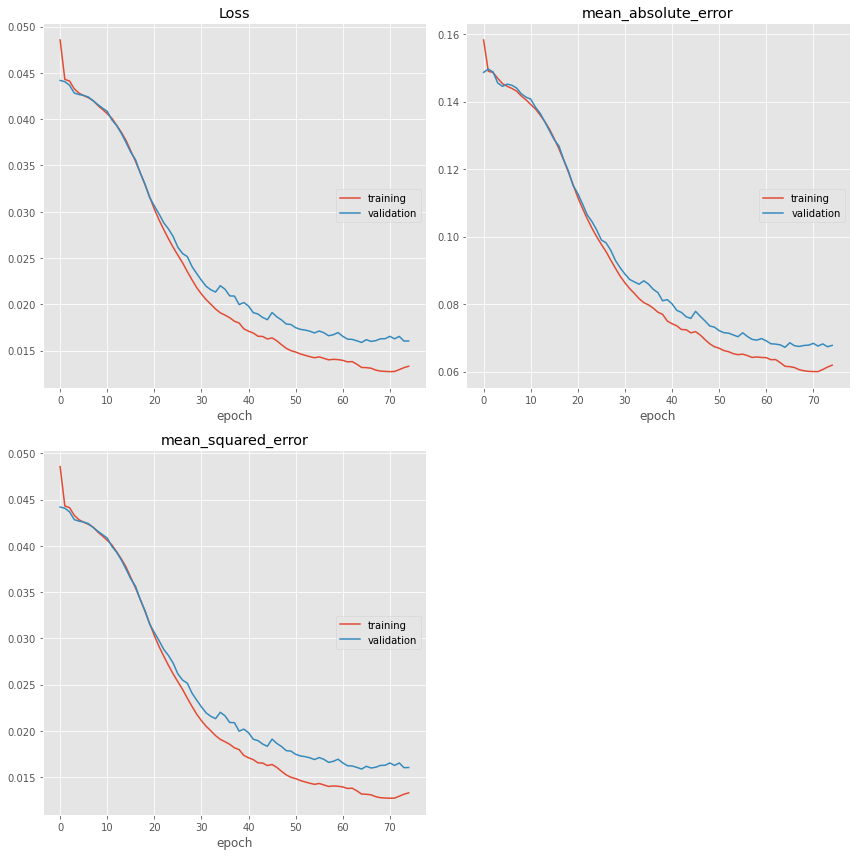

Loss
	training         	 (min:    0.013, max:    0.049, cur:    0.013)
	validation       	 (min:    0.016, max:    0.044, cur:    0.016)
mean_absolute_error
	training         	 (min:    0.060, max:    0.158, cur:    0.062)
	validation       	 (min:    0.067, max:    0.150, cur:    0.068)
mean_squared_error
	training         	 (min:    0.013, max:    0.049, cur:    0.013)
	validation       	 (min:    0.016, max:    0.044, cur:    0.016)
92/92 [==============================] - 17s 185ms/step - loss: 0.0133 - mean_squared_error: 0.0133 - mean_absolute_error: 0.0619 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.0678


INFO:tensorflow:Assets written to: saved_models/model_ep1000_b256_seq2_2022-07-16 14:21:46/assets


INFO:tensorflow:Assets written to: saved_models/model_ep1000_b256_seq2_2022-07-16 14:21:46/assets


In [62]:
##### Step 5 - Fit the model on the dataset
history = model.fit(train_ds, # input data, # target data
                    batch_size=1, # Number of samples per gradient update. If unspecified, batch_size will default to 32.
                    epochs=1000, # default=1, Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided
                    verbose=1, # default='auto', ('auto', 0, 1, or 2). Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch. 'auto' defaults to 1 for most cases, but 2 when used with ParameterServerStrategy.
                    callbacks=[ PlotLossesKeras(),EarlyStopping(patience=10, restore_best_weights=True)], # default=None, list of callbacks to apply during training. See tf.keras.callbacks
                    #validation_split=0.2, # default=0.0, Fraction of the training data to be used as validation data. The model will set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch. 
                    validation_data=test_ds, # default=None, Data on which to evaluate the loss and any model metrics at the end of each epoch. 
                    shuffle=False, # default=True, Boolean (whether to shuffle the training data before each epoch) or str (for 'batch').
                    class_weight=None, # default=None, Optional dictionary mapping class indices (integers) to a weight (float) value, used for weighting the loss function (during training only). This can be useful to tell the model to "pay more attention" to samples from an under-represented class.
                    sample_weight=None, # default=None, Optional Numpy array of weights for the training samples, used for weighting the loss function (during training only).
                    initial_epoch=0, # Integer, default=0, Epoch at which to start training (useful for resuming a previous training run).
                    steps_per_epoch=None, # Integer or None, default=None, Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch. When training with input tensors such as TensorFlow data tensors, the default None is equal to the number of samples in your dataset divided by the batch size, or 1 if that cannot be determined. 
                    validation_steps=None, # Only relevant if validation_data is provided and is a tf.data dataset. Total number of steps (batches of samples) to draw before stopping when performing validation at the end of every epoch.
                    validation_batch_size=None, # Integer or None, default=None, Number of samples per validation batch. If unspecified, will default to batch_size.
                    validation_freq=1, # default=1, Only relevant if validation data is provided. If an integer, specifies how many training epochs to run before a new validation run is performed, e.g. validation_freq=2 runs validation every 2 epochs.
                    max_queue_size=10, # default=10, Used for generator or keras.utils.Sequence input only. Maximum size for the generator queue. If unspecified, max_queue_size will default to 10.
                    workers=1, # default=1, Used for generator or keras.utils.Sequence input only. Maximum number of processes to spin up when using process-based threading. If unspecified, workers will default to 1.
                    use_multiprocessing=True, # default=False, Used for generator or keras.utils.Sequence input only. If True, use process-based threading. If unspecified, use_multiprocessing will default to False. 
                   )
now = datetime.now()
current_time = now.strftime('%Y-%m-%d %H:%M:%S')
model.save(f'saved_models/model_ep{EPOCHS}_b{BATCH_SIZE}_seq{SEQ_LEN}_{current_time}')

In [63]:
##### Step 7 - Print Performance Summary
print("")
print('-------------------- Model Summary --------------------')
model.summary() # print model summary
print("")
print('-------------------- Weights and Biases --------------------')
print("Too many parameters to print but you can use the code provided if needed")
print("")
#for layer in model.layers:
#    print(layer.name)
#    for item in layer.get_weights():
#        print("  ", item)
#print("")

# Print the last value in the evaluation metrics contained within history file
print('-------------------- Evaluation on Training Data --------------------')
for item in history.history:
    print("Final", item, ":", history.history[item][-1])
print("")

# Evaluate the model on the test data using "evaluate"
print('-------------------- Evaluation on Test Data --------------------')
results = model.evaluate(test_x, test_y)
print("")
print('-------------------- Accuracy and Score --------------------')
test_data = data[(data['Day']>=199)&(data['Day']<=200)]
test_data.drop(['TurbID','Day'], axis = 1, inplace = True)
test_data = test_data.to_numpy().reshape(-1, *train_x.shape[1:])

submission['Patv'] =model.predict(test_data).reshape(-1,train_x.shape[2])[:,-1]
current_time = now.strftime('%Y-%m-%d %H:%M:%S')
score = evaluate(submission)
submission.to_csv(f"output/prediction_{current_time}_score{round(score)}.csv", index=False)
print('\n --- Overall Score --- \n\t{}'.format(score))



-------------------- Model Summary --------------------
Model: "GRU-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden-GRU-Encoder-Layer (B  (None, 512)              411648    
 idirectional)                                                   
                                                                 
 Repeat-Vector-Layer (Repeat  (None, 288, 512)         0         
 Vector)                                                         
                                                                 
 Hidden-GRU-Decoder-Layer (B  (None, 288, 512)         1182720   
 idirectional)                                                   
                                                                 
 Output-Layer (TimeDistribut  (None, 288, 10)          5130      
 ed)                                                             
                                                                 


NameError: name 'test_y' is not defined

1) Training set

In [73]:
y_true = train_y_scaled
y_pred = model.predict(train_x_scaled)

733/733 [==============================] - 28s 38ms/step


In [80]:
y_true = y_true.reshape(-1, y_true.shape[2])
y_pred = y_pred.reshape(-1, y_pred.shape[2])
y_true_descaled = scaler.inverse_transform(y_true)
y_pred_descaled = scaler.inverse_transform(y_pred)

In [91]:
y_pred_descaled[:,-2] = np.clip(y_pred_descaled[:,-2], -0.3, 1550)


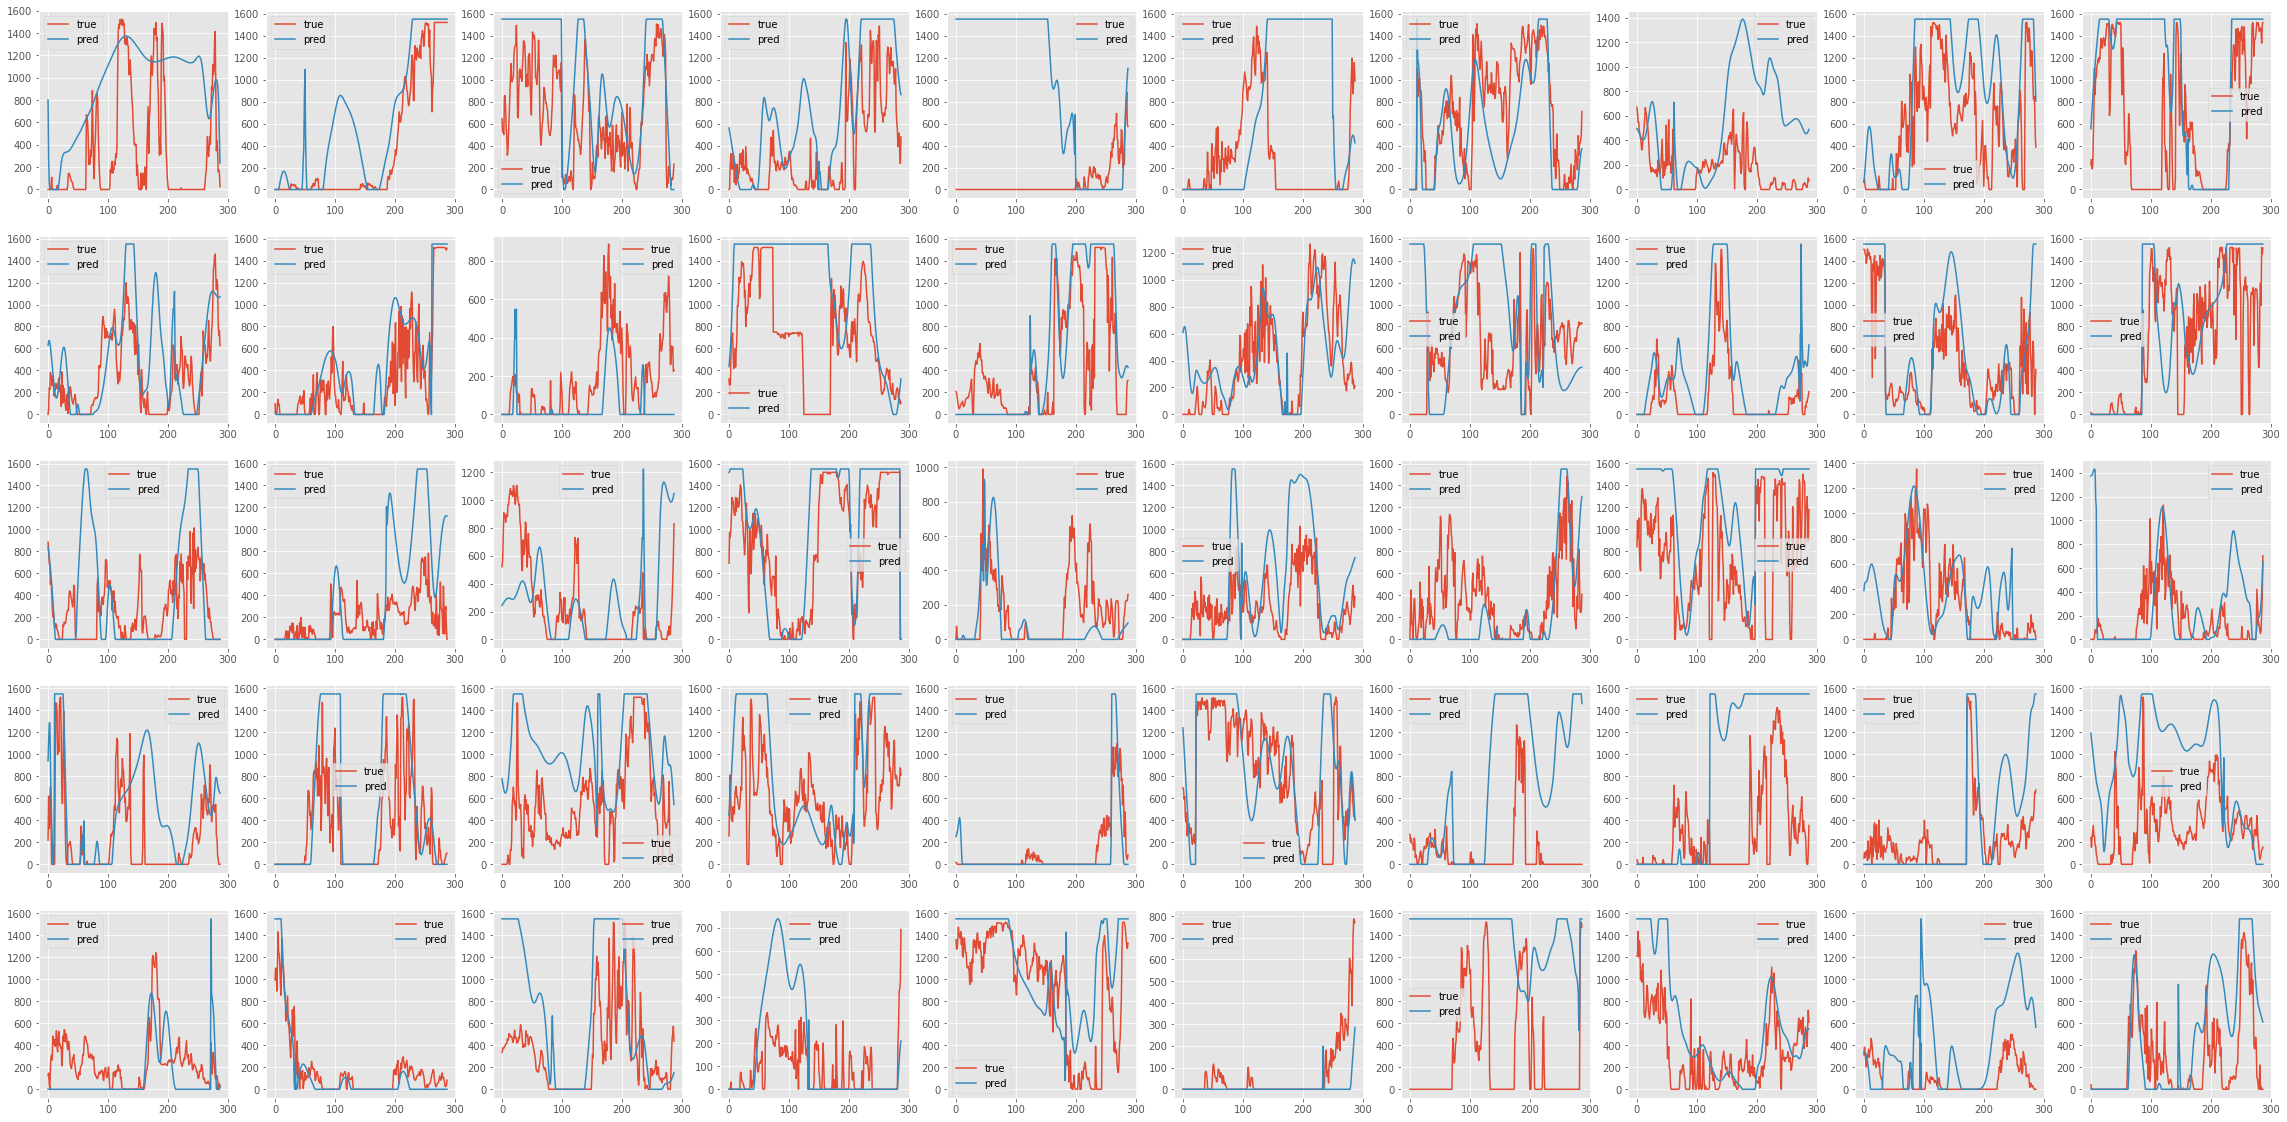

In [92]:

len_turb = len(y_true)//134

plt.style.use('ggplot')
fig, axes = plt.subplots(5, 10, figsize=(40, 20))
for i, ax in enumerate(axes.flatten()):  # i: turbID
    y_t = y_true_descaled[len_turb*i:len_turb*(i+1)][:,-1][:144*2]
    y_p = y_pred_descaled[len_turb*i:len_turb*(i+1)][:,-2][:144*2]
    ax.plot(y_t, label='true')
    ax.plot(y_p, label='pred')
    ax.legend()

2) Validation set

In [ ]:
y_true = val_y_scaled[:, :, -2]
y_pred = model.predict(val_x_scaled)[:, :, -2]

84/84 [==============================] - 3s 37ms/step


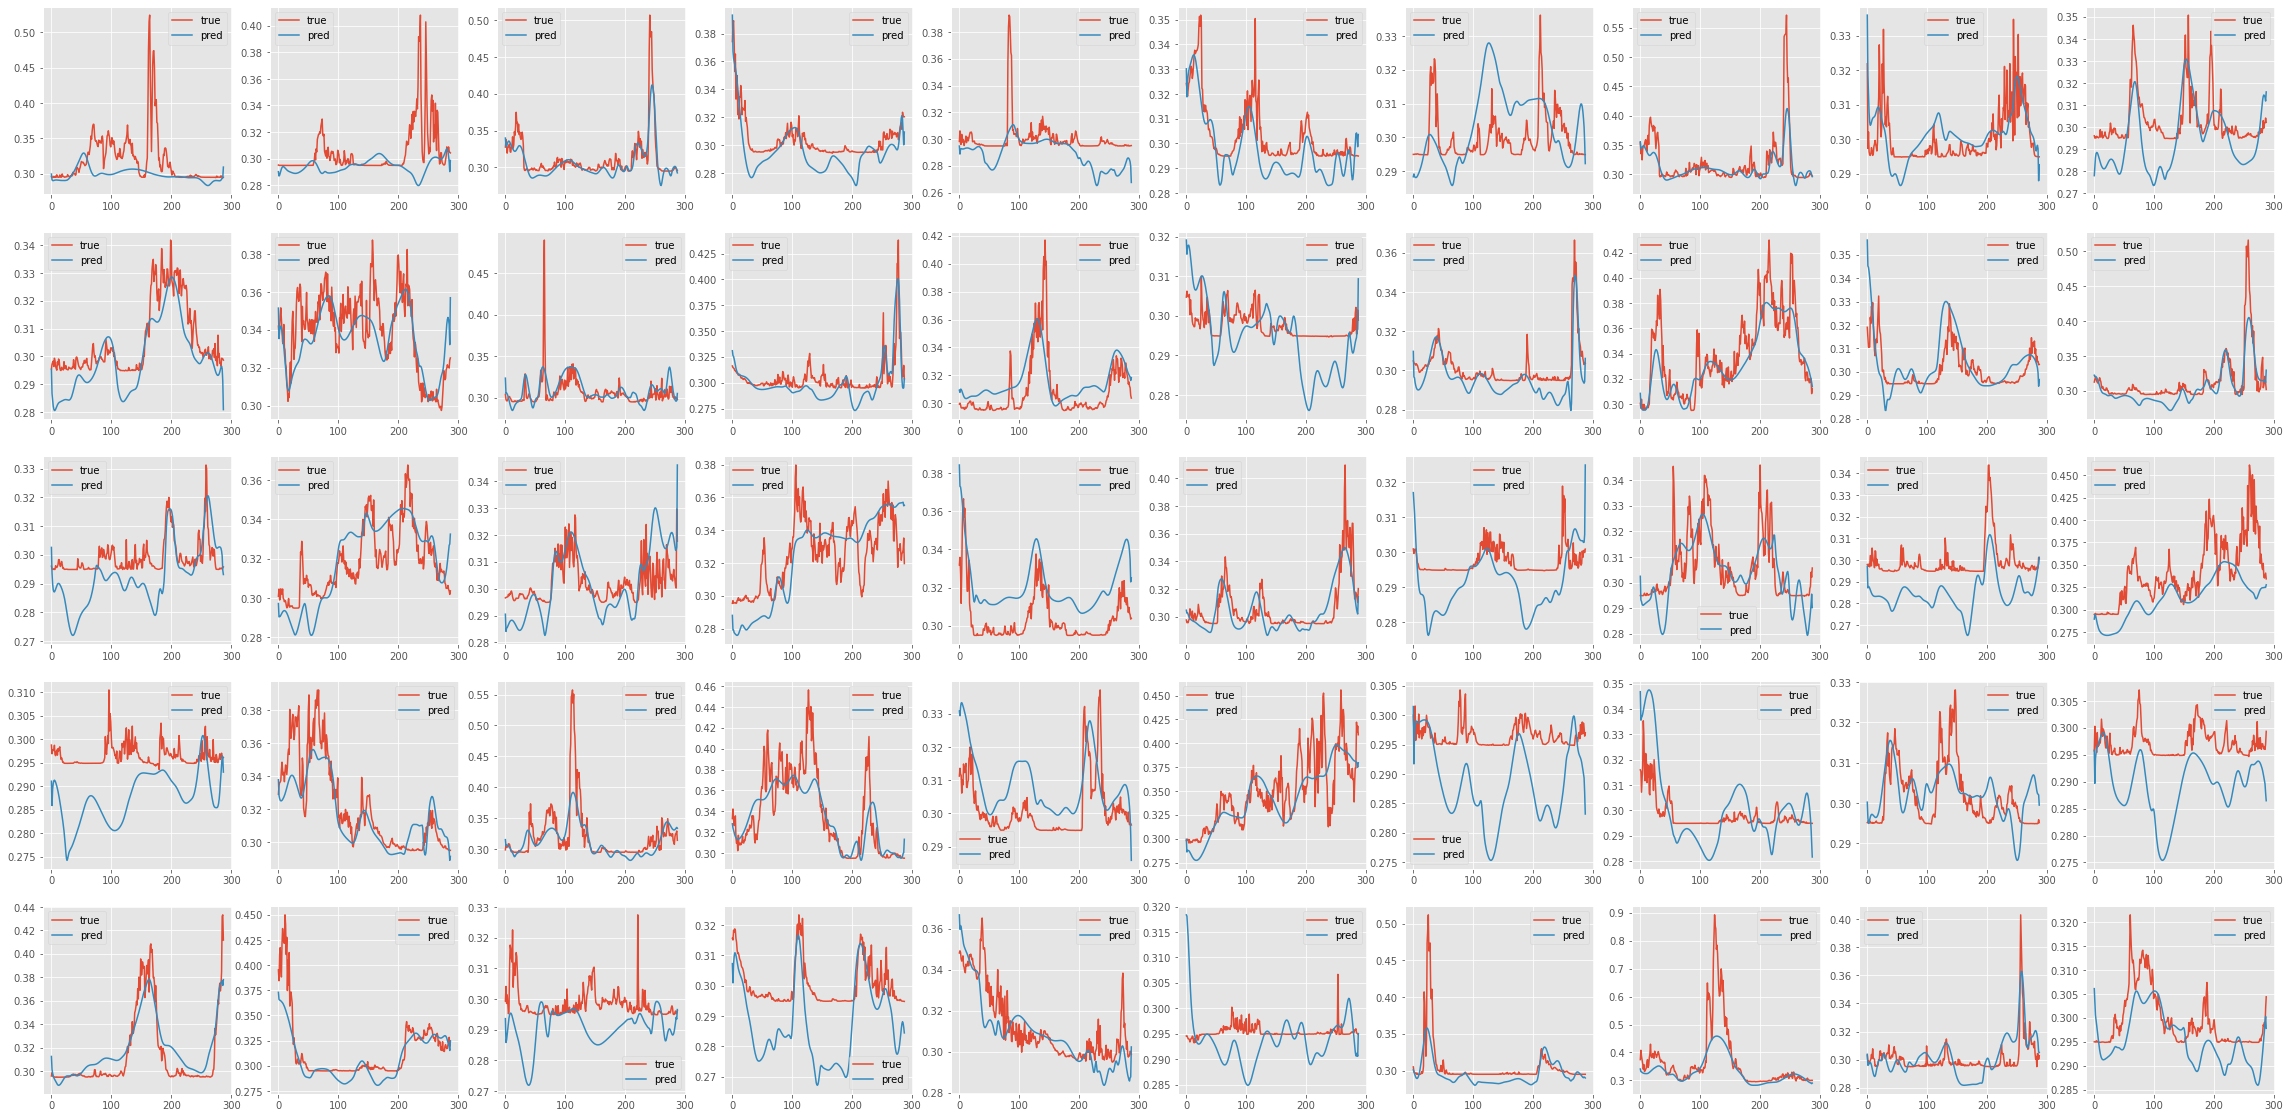

In [68]:

len_turb = len(y_true)//134

plt.style.use('ggplot')
fig, axes = plt.subplots(5, 10, figsize=(40, 20))
for i, ax in enumerate(axes.flatten()):  # i: turbID
    y_t = y_true[len_turb*i:len_turb*(i+1)].reshape(-1)[:144*2]
    y_p = y_pred[len_turb*i:len_turb*(i+1)].reshape(-1)[:144*2]
    ax.plot(y_t, label='true')
    ax.plot(y_p, label='pred')
    ax.legend()

# Result

In [ ]:
print('-------------------- Accuracy and Score --------------------')
test_data = data[(data['Day']>=199)&(data['Day']<=200)]
test_data.drop(['TurbID','Day'], axis = 1, inplace = True)
test_data = test_data.to_numpy().reshape(-1, *train_x.shape[1:])

submission['Patv'] =model.predict(test_data).reshape(-1,train_x.shape[2])[:,-1]
current_time = now.strftime('%Y-%m-%d %H:%M:%S')
score = evaluate(submission)
submission.to_csv(f"output/prediction_{current_time}_score{round(score)}.csv", index=False)
print('\n --- Overall Score --- \n\t{}'.format(score))
